# Finding the Higgs Boson

<div style="border:2px solid #4CAF50; padding:10px; background-color:#f9f9f9;">

**Note: AI Declaration**

AI was used in the following ways in this assignment:  
- GitHub Copilot to autocomplete parts of code (e.g., train/test split, plotting function calls).  
- To write plotting + data presenting functions, avoiding repetitive formatting like `{mi_sep.errors['mu_VBF']:.4f}`.  
- Writing some docstrings for functions I wrote.  

</div>


## Import packages

In [1]:
# Packages that may need to be installed
#!pip install iminuit
#!pip install mplhep
#!pip install seaborn

In [2]:
import copy
import logging
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import seaborn as sns
from iminuit import Minuit
from functools import partial
logging.getLogger("iminuit").setLevel(logging.WARNING)
plt.style.use(hep.style.CMS)

## Introduction

This exercise is based on a real problem in particle physics. The objective is to identify the Higgs boson using simulated data that replicates what is expected to be observed by the CMS experiment at the Large Hadron Collider (LHC) at CERN. The LHC collides protons at extremely high energies. CMS collects roughly 1000 proton collision events per second, so there is a lot of data to play with!

To predict what we should observe in the CMS detector, physicists generate Monte Carlo (MC) simulations, datasets whose distributions model the expected outcomes of various physical processes. The specific task here is to distinguish a signal (S) of Higgs bosons decaying into $\tau$ leptons from a much larger background (B) of $Z$ bosons decaying into $\tau$ leptons. Diagrams of the two processes are shown below.

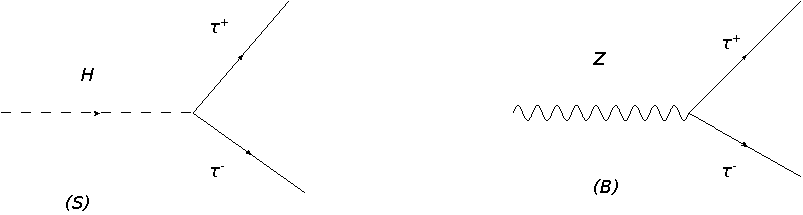

The $\tau$ leptons can then decay hadronically (h) or leptonically - so either an electron (e) or a muon ($\mu$) as shown below:

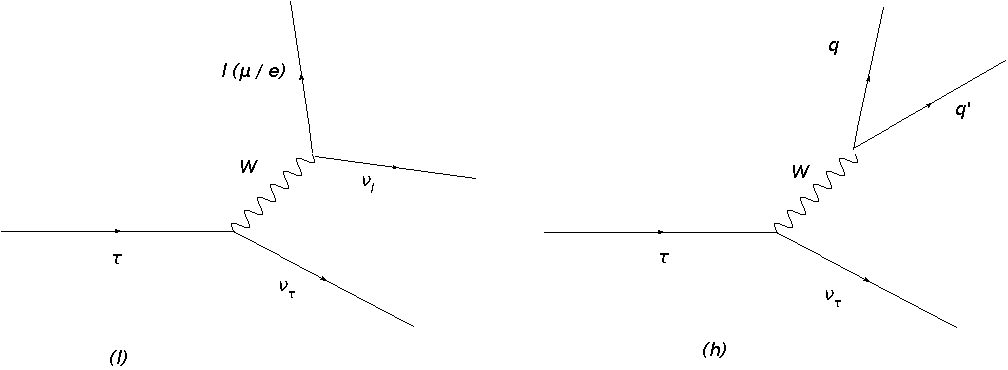

Now the Z boson has a mass of ~90 GeV and the Higgs boson a mass of ~125 GeV, so naively you would think that this would be easy, as you could just reconstruct all the particles and find the invariant mass. However, the problem is that we cannot reconstruct any of the neutrinos ($\nu$), so we have to use other variables as well.

There is a slight complication in that the Higgs can be produced in different ways. The most likely two being gluon fusion (ggH) and vector boson fusion (VBF). With ggH happening about 10 the rate of VBF, however VBF events have some topological structures that might help to identify them. The processes are shown below:

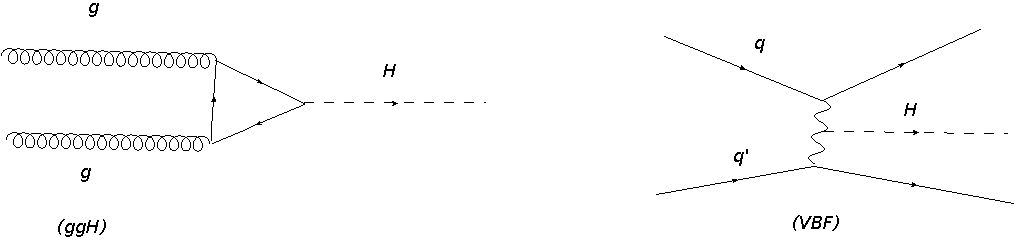


### About 2000 Z bosons are produced for every Higgs boson that is produced ###

## Datasets

You are given simulated MC datasets separated by decay channels:  where one $\tau$ has decayed to an electron and the other hadronically (et), where one $\tau$ has decayed to a $\mu$ and the other hadronically (mt), and where both have decayed hadronically (tt). 

They are also separated by process: Z bosons, Higgs from ggH and Higgs from VBF. 

In each of these datasets, there are a series of event variables which are explained below.


In [3]:
channels = ["et","mt","tt"] # so tau can decay in 3 ways. either into electron,muon or hadronic shown by et,mt,tt respectively
processes = ["Z","ggH","VBF"] #want to sepearate these processes, channels are the predictors/features

dataset = {}
for channel in channels:
    dataset[channel] = {}
    for process in processes:
        url = f"https://raw.githubusercontent.com/gputtley/ML-Assessment-3/master/{channel}_{process}.pkl"
        dataset[channel][process] = pd.read_pickle(url)

An example of the tt channel DY events are shown below.

In [4]:
display(dataset["tt"]["Z"])

,dR,dijetpt,dphi,eta_1,eta_2,jdeta,jpt_1,jpt_2,m_vis,met,...,mva_dm_2,n_deepbjets,n_jets,pt_1,pt_2,pt_tt,pt_vis,q_1,q_2,svfit_mass
0,2.414482,-9999.000000,2.373276,0.288935,-0.155231,-9999.000000,42.114372,-9999.000000,86.581536,30.150600,...,1.0,0.0,1.0,48.971975,42.047497,56.198355,34.711005,1.0,-1.0,122.340492
1,0.905428,105.572952,-0.870895,-1.301026,-1.053353,0.309145,202.115177,155.836621,47.121035,74.118637,...,0.0,0.0,3.0,67.624255,42.424370,167.510356,100.343648,-1.0,1.0,81.164604
2,1.786701,-9999.000000,-1.725332,-1.701998,-1.237745,-9999.000000,81.649279,-9999.000000,68.659531,24.880594,...,1.0,0.0,1.0,43.318895,43.055293,77.721734,56.179411,-1.0,1.0,90.083839
3,3.261100,-9999.000000,-3.132327,0.415204,-0.492155,-9999.000000,-9999.000000,-9999.000000,272.676875,79.535843,...,10.0,0.0,0.0,161.267835,94.447914,12.772213,66.829704,1.0,-1.0,394.964371
4,2.808269,44.089321,2.768047,-0.933327,-1.406919,0.360274,51.960214,24.052974,110.202417,13.298456,...,1.0,0.0,1.0,71.982552,41.230914,23.789963,36.810342,-1.0,1.0,121.641335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10554,2.434000,-9999.000000,-2.364294,-0.703203,-1.281535,-9999.000000,39.474594,-9999.000000,84.618685,10.248204,...,10.0,0.0,1.0,45.458845,41.776954,43.308454,33.232148,-1.0,1.0,103.120327
10555,0.650817,321.734161,-0.201372,0.496136,1.115016,0.998327,297.371251,40.722552,59.738937,107.629318,...,2.0,0.0,2.0,115.287050,70.994218,290.712892,185.391304,-1.0,1.0,86.510059
10556,1.468973,129.886017,1.302548,0.315466,0.994619,3.097943,163.557993,59.898794,89.913374,55.855453,...,2.0,0.0,3.0,74.985983,55.278327,149.554641,104.287329,1.0,-1.0,133.496468
10557,3.096478,-9999.000000,3.002873,0.769950,0.014352,-9999.000000,-9999.000000,-9999.000000,148.423309,33.579464,...,2.0,0.0,0.0,71.921759,66.870102,23.317015,10.859038,-1.0,1.0,163.827553


### Variables definitions
If a variable shown below ends with {1,2}, this means that the variable exists for both the tau decay products 1 and 2. 1 refers to the leading transverse momentum hadronic tau in tt channel and the electron or muon in the et or mt channel. 2 refers to the subleading transverse momentum hadronic tau in tt channel and the hadronic tau in the et and mt channel. Any variable that takes the value -9999 is undefined for that event.

- dR: Distance between the two tau decay products.
- dijetpt: Total transverse momentum of the two highest transverse momentum jets in the event.
- dphi: The angle phi between the two tau decay products.
- eta_{1,2}: The detector eta of the tau decay products.
- jdeta: The eta between the two highest transverse momentum jets in the event.
- jpt_1: The transverse momentum of the leading transverse momentum jet in the event.
- jpt_2: The transverse momentum of the subleading transverse momentum jet in the event.
- m_vis: The reconstructed mass of the visibile ditau decay products.
- met: The missing transverse energy in the event.
- met_dphi_{1,2}: The angle phi between the met and the tau decay product.
- mjj: The reconstructed mass of the two highest transverse momentum jets in the event.
- mt_{1,2}: The transverse mass between the met and the tau decay product.
- mt_lep: The transverse mass between the two tau decay products.
- mt_tot: The sum in quadrature of mt_1, mt_2 and mt_lep.
- mva_dm_{1,2}: The predicted decay mode of the hadronic tau (1 only available for tt channel).
- n_deepbjets: The number of b tagged jets in the event.
- n_jets: The number of jets in the events.
- pt_{1,2}: The transverse momentum of the tau decay product.
- pt_tt: The reconstructed ditau + met transverse momentum.
- pt_vis: The reconstructed ditau transverse momentum.
- q_{1,2}: The charge of the tau decay product.
- svfit_mass: A likelihood reconstruction of the ditau mass.

## Task

We want you to use simulated events to try to optimise a search for the signal Higgs bosons. To do this, you will need to attempt to separate the signal Higgs boson events from the background Z boson events. Your assignment is to produce a binning of the dataset that provides the most precise binned likelihood fit for the rate of the signal. The bins should be chosen by using the output of a machine learning algorithm.

Things you may want to try:
- Try both binary (S vs B) and multiclass (Z, ggH, VBF) classifiers.
- Try different machine learning classification models.
- Try training classifiers both on the decay channels (et, mt, tt) individually and merged into one dataset.
- Try building the histograms from the binary signal classifier score.
- Try building 2D histograms from the multiclass output scores.

build different classifiers, try a few ! \
deal with different decay channels, could merge into one df or train a dif classifier for each


## Classical solution

It is common in particle physics to compare the performance of a machine learning algorithm to that of a classical algorithm. This will act as a baseline solution, to show the improvement you can get with machine learning.

Here we show an example of using a binned m_vis histogram to measure the precision using a binned likelihood fit, where all channels are merged together.

First, we build the histograms.

In [5]:
bins = np.linspace(50,200,num=51)
variable = "m_vis"

combined_channels_dataset = {}
histograms = {}
for proc in processes:
  combined_channels_dataset[proc] = pd.concat([dataset[ch][proc] for ch in channels])
  histograms[proc] = np.histogram(combined_channels_dataset[proc].loc[:,variable], bins=bins)[0]

The current length of the simulated datasets do not represent the number of events expected. Therefore, we scale them to what is expected. In your studies, you should use the same function.

In [6]:
def scale_histograms_to_correct_yield(histograms):
  """
  Scale histograms for different processes to the expected yields.
  
  Args:
    histograms (dict): Dictionary of histograms with keys "Z", "ggH", "VBF".
                       Each value is a NumPy array representing bin counts.

  Returns:
    dict: The input dictionary with histograms scaled to the expected yields.
  """
  for proc in ["Z","ggH","VBF"]:
    histograms[proc] = histograms[proc].astype(float)
  histograms["Z"] *= 8.4
  histograms["ggH"] *= 0.034
  histograms["VBF"] *= 0.011
  return histograms

In [7]:
scaled_histograms = scale_histograms_to_correct_yield(histograms)

We can then plot the histograms. Here we also scale up the signal (just for the plot) so it is visible.

In [8]:
def plot_histograms(hist, bins, x_label, title_right=None, scale_signal=10):
  """
  Plot stacked histograms for multiple processes with optional signal scaling.

  Args:
    hist (dict): Dictionary of histograms with process names as keys and
                 NumPy arrays of bin counts as values.
    bins (array-like): Bin edges for the histograms.
    x_label (str): Label for the x-axis.
    title_right (str, optional): Text displayed in the top-right corner of the plot.
    scale_signal (float, optional): Factor to scale signal histograms ("ggH" and "VBF")
                                    for better visibility on the plot. Set to None to disable.
  """
  hist = copy.deepcopy(hist)
  if scale_signal is not None:
    for sig_proc in ["ggH","VBF"]:
      hist[f"{scale_signal} x {sig_proc}"] = scale_signal*hist[sig_proc]
      del hist[sig_proc]

  if title_right is None:
    title_right = ""

  fig, ax = plt.subplots(1, 1, figsize=[8,6])
  rgb_palette = sns.color_palette("Set2", len(hist.keys()))
  step_edges = np.append(bins, 2*bins[-1]-bins[-2])

  for ind, (k, v) in enumerate(hist.items()):
    if ind == 0: bottom = None
    ax.bar(
      bins[:-1],
      v,
      bottom=bottom,
      width=np.diff(bins),
      align='edge',
      alpha=1.0,
      label=k,
      color=tuple(x for x in rgb_palette[ind]),
      edgecolor=None
    )
    if bottom is None:
      bottom = v*1.0
    else:
      bottom += v

    step_histvals = np.append(np.insert(bottom,0,0.0),0.0)
    ax.step(step_edges, step_histvals, color='black')

  ax.text(1.0, 1.0, title_right, verticalalignment='bottom', horizontalalignment='right',
          transform=ax.transAxes, fontsize=22)
  plt.ylim(10, np.max(bottom)*2)
  plt.xlim(bins[0], bins[-1])
  plt.xlabel(x_label)
  plt.ylabel("Events")
  plt.yscale('log')
  plt.legend(loc='upper right')
  plt.show()

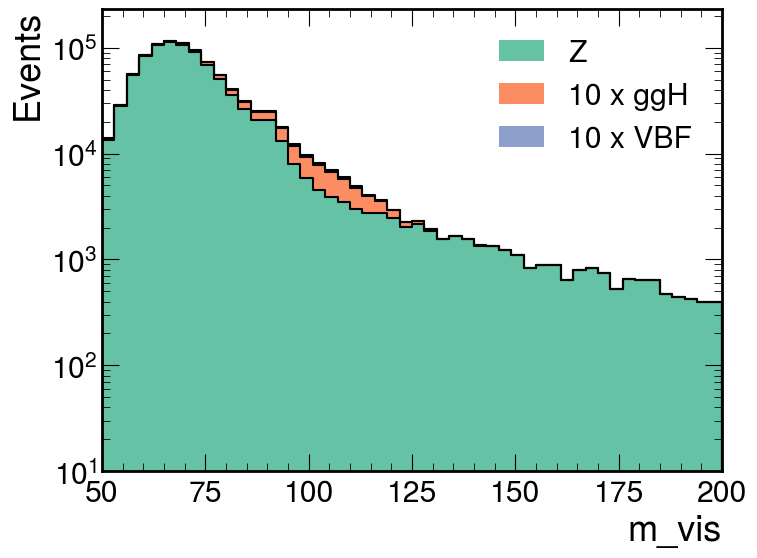

In [9]:
plot_histograms(scaled_histograms, bins, variable)

One thing we must check before doing a binned likelihood fit, is that we have enough events in every bin. If this steps is not passed, make the bins used coarser. Run this to make sure ur code is good

In [10]:
def check_events_numbers(histograms, threshold=10):
  """
  Check that each bin in the summed histograms has at least a minimum number of events.

  Args:
    histograms (dict): Dictionary of histograms with process names as keys and
                       NumPy arrays of bin counts as values.
    threshold (int, optional): Minimum number of events required in each bin. Default is 10.

  Raises:
    ValueError: If any bin in the summed histogram has fewer than `threshold` events.
  """
  summed_histogram = np.sum(list(histograms.values()), axis=0)
  if (summed_histogram < threshold).any():
    raise ValueError("Not enough events in one or more of the histogram bins")

In [11]:
check_events_numbers(scaled_histograms)

We have two choices for the type of fit.

The first is a fit for an inclusive signal strength modifier (that scales both the rate of ggH and VBF together).

The second is a fit for the signal strength modifiers mu_ggH (that scales the rate of the ggH process) and mu_VBF (that scales the rate of the VBF process) simultaneously.

As we are fitting for the expected values, the fit should return signal strength modifiers of approximately 1 with some uncertainty.

The metric we are interested in is the precision of the measurement of each signal strength modifier. This tells us to what precision we can measure the rate of that process. You want the percentage to be as small as possible.

We build two types of likelihood functions and we perform the fit with minuit.

In [12]:
def nll_merge(expected_counts_per_process, mu):
  """
  Compute the negative log-likelihood (NLL) assuming a single signal strength parameter
  for both ggH and VBF processes combined.

  Args:
    expected_counts_per_process (dict): Dictionary with keys "Z", "ggH", "VBF" and
                                        values as expected bin counts (arrays).
    mu (float): Signal strength multiplier applied to ggH and VBF.

  Returns:
    float: Negative log-likelihood value.
  """
  observed_counts = expected_counts_per_process["Z"] + expected_counts_per_process["ggH"] + expected_counts_per_process["VBF"]
  expected_counts = expected_counts_per_process["Z"] + (mu * (expected_counts_per_process["ggH"] + expected_counts_per_process["VBF"]))
  return np.sum(expected_counts - observed_counts * np.log(expected_counts))


def nll_separate(expected_counts_per_process, mu_ggH, mu_VBF):
  """
  Compute the negative log-likelihood (NLL) using separate signal strength parameters
  for ggH and VBF processes.

  Args:
    expected_counts_per_process (dict): Dictionary with keys "Z", "ggH", "VBF" and
                                        values as expected bin counts (arrays).
    mu_ggH (float): Signal strength multiplier for ggH.
    mu_VBF (float): Signal strength multiplier for VBF.

  Returns:
    float: Negative log-likelihood value.
  """
  observed_counts = expected_counts_per_process["Z"] + expected_counts_per_process["ggH"] + expected_counts_per_process["VBF"]
  expected_counts = expected_counts_per_process["Z"] + (mu_ggH * expected_counts_per_process["ggH"]) + (mu_VBF * expected_counts_per_process["VBF"])
  return np.sum(expected_counts - observed_counts * np.log(expected_counts))

In [13]:
nll = partial(nll_merge, scaled_histograms)
m = Minuit(nll, mu=1.0)
m.migrad()
print(f"mu = {round(m.values['mu'],4)} ± {round(m.errors['mu'],4)}")

mu = 1.0 ± 0.1008


In [14]:
nll = partial(nll_separate, scaled_histograms)
m = Minuit(nll, mu_ggH=1.0, mu_VBF=1.0)
m.migrad()
print(f"mu_ggH = {round(m.values['mu_ggH'],4)} ± {round(m.errors['mu_ggH'],4)}")
print(f"mu_VBF = {round(m.values['mu_VBF'],4)} ± {round(m.errors['mu_VBF'],4)}")

mu_ggH = 1.0 ± 0.5694
mu_VBF = 1.0 ± 4.8929


mu is how often is occurs/ how often we expect

This gives us a precision of ~10% on the total signal rate, and a precision of ~57% for ggH and ~490% for VBF.

This example is very basic and you get very poor performance for VBF. If you look closely at the simulated data you will see that VBF is more prominent when n_jets >= 2, jdeta > 2.5 and mjj > 200. Therefore, we define two orthogonal splits of the data, one that targets VBF events and one that targets ggH. We now apply all the same steps as we did in the previous example.

In [15]:
# Make histograms
vbf_like_query = "(n_jets >= 2) & (jdeta > 2.5) & (mjj > 200)"
variable = "m_vis"
vbf_like_bins, ggH_like_bins = np.linspace(50, 200, 21), np.linspace(50, 200, 51)

vbf_like_dataset = {p: combined_channels_dataset[p].query(vbf_like_query) for p in processes}
ggH_like_dataset = {p: combined_channels_dataset[p].query(f"not ({vbf_like_query})") for p in processes}

vbf_like_histograms = {p: np.histogram(vbf_like_dataset[p][variable], bins=vbf_like_bins)[0] for p in processes}
ggH_like_histograms = {p: np.histogram(ggH_like_dataset[p][variable], bins=ggH_like_bins)[0] for p in processes}

In [16]:
# Scale histograms
scaled_vbf_like_histograms = scale_histograms_to_correct_yield(vbf_like_histograms)
scaled_ggH_like_histograms = scale_histograms_to_correct_yield(ggH_like_histograms)

# Check binning is ok
check_events_numbers(scaled_vbf_like_histograms)
check_events_numbers(scaled_ggH_like_histograms)

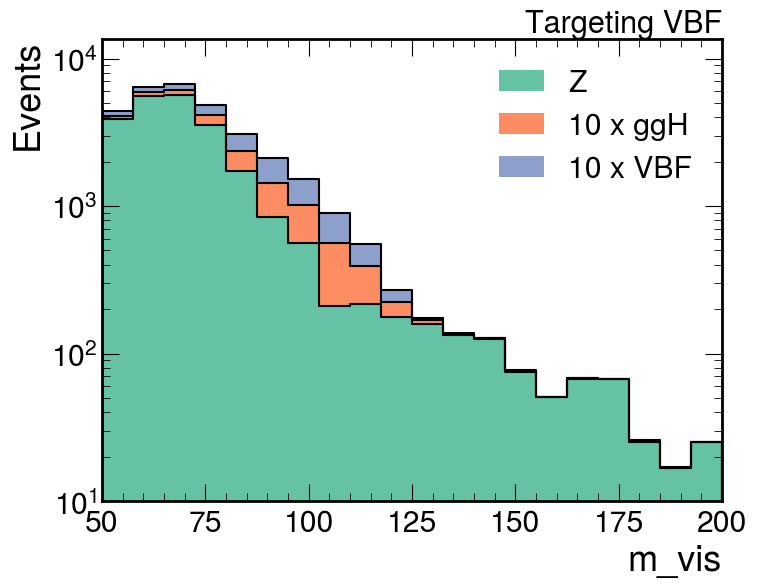

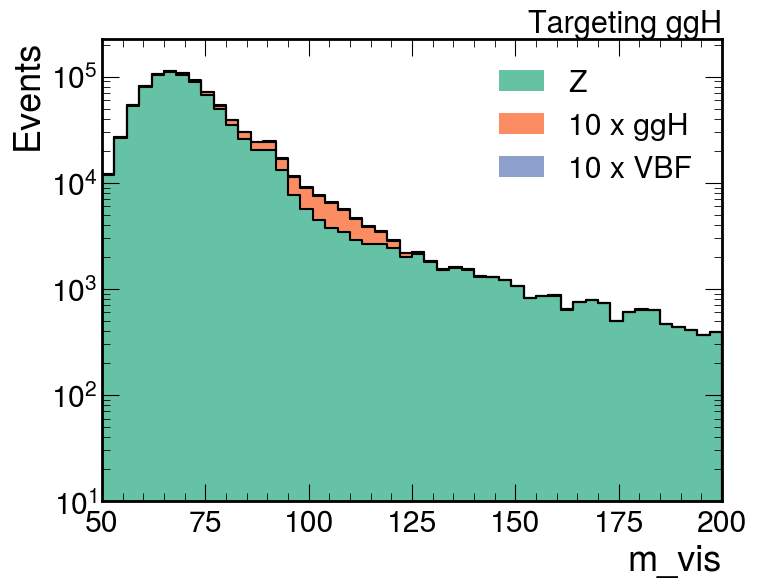

In [17]:
# Plot histograms
plot_histograms(scaled_vbf_like_histograms, vbf_like_bins, variable, title_right="Targeting VBF")
plot_histograms(scaled_ggH_like_histograms, ggH_like_bins, variable, title_right="Targeting ggH")

You can see that VBF is now visible in the plot! This is a good sign, we can now test the binning by performing the fits. As the histograms are from orthogonal splits in the data, we can concatenate the histograms for the binned likelihood fit.

In [18]:
# Concatenate histograms
concatenated_histograms = {proc: np.concatenate([scaled_vbf_like_histograms[proc], scaled_ggH_like_histograms[proc]]) for proc in processes}

In [19]:
# Run fit for mu
nll = partial(nll_merge, concatenated_histograms)
m = Minuit(nll, mu=1.0)
m.migrad()
print(f"mu = {round(m.values['mu'],4)} ± {round(m.errors['mu'],4)}")

mu = 1.0 ± 0.0923


In [20]:
# Run fit for mu_ggH and mu_VBF
nll = partial(nll_separate, concatenated_histograms)
m = Minuit(nll, mu_ggH=1.0, mu_VBF=1.0)
m.migrad()
print(f"mu_ggH = {round(m.values['mu_ggH'],4)} ± {round(m.errors['mu_ggH'],4)}")
print(f"mu_VBF = {round(m.values['mu_VBF'],4)} ± {round(m.errors['mu_VBF'],4)}")

mu_ggH = 1.0 ± 0.1249
mu_VBF = 1.0 ± 0.3578


This now does much better for ggH (57% -> 12%) and VBF (490% -> 35%). The multidimensionality of the dataset is important in optimising the Higgs boson search! But this is just a classical example that uses more than one variable. You can do much better with machine learning.

The CMS published analysis managed a statistical precision of:
   * mu_ggH: 9%
   * mu_VBF: 18%
   * mu: 6%

See if you can beat it!

## Your work

### A3 Submission by Mihir Koka - Plan and overview

- Data is simulated using montecarlo, we have events provided for three decay channels: `et`, `mt`, `tt`, and three processes: background $Z$ and signals $ggH$, $VBF$. We load them from the given URLs into pandas. Features are event level kinematics and value of $-9999$ means undefined/NaN.
- Goal: use an ML classifier to create bins that give the most precise binned likelihood fit for the signal rate(s).
- Two fits to evaluate precision:
  - Inclusive: a single signal strength $\mu$ that scales both $ggH$ and $VBF$ together.
  - Separate: two modifiers $\mu_{\mathrm{ggH}}$ and $\mu_{\mathrm{VBF}}$ fitted simultaneously.

We don’t fit raw events. We build histograms (counts per bin) for each process in the chosen 1D/2D space (classical example used $m_{\mathrm{vis}}$ we’ll use ML scores). Templates are then scaled to expected yields with the given functions provided above

---

### Likelihood we are optimizing (binned, Poisson)

- Let $n_b$ be the observed counts in bin $b$
- Let $\lambda_b(\theta)$ be the expected counts in bin $b$, given parameters $\theta$.

For the inclusive fit:
- $\lambda_b(\mu) \;=\; Z_b \;+\; \mu \,\big( (ggH)_b + (VBF)_b \big)$

For the separate fit:
- $\lambda_b(\mu_{\mathrm{ggH}}, \mu_{\mathrm{VBF}}) \;=\; Z_b \;+\; \mu_{\mathrm{ggH}} \,(ggH)_b \;+\; \mu_{\mathrm{VBF}} \,(VBF)_b$

Negative log-likelihood (dropping constants): 
- $\text{NLL}(\theta) \;=\; \sum_b \left[ \lambda_b(\theta) \;-\; n_b \,\ln \lambda_b(\theta) \right]$

Smaller error bars (feedback suggestion from A1) on $\mu$ (or on $\mu_{\mathrm{ggH}}, \mu_{\mathrm{VBF}}$) = better precision.

---

### Where the numbers come from

- The MC files give per-event features and the true process. We build per-process histograms in the variable we choose (baseline: ML score).
- We then scale to expected yields using the provided function:

- We must ensure enough events per bin: a simple check that each bin of the summed template has at least a threshold count 
---

### How I’ll handle channels and labels

- We can merge all channels into one training set, or train one model per channel and later concatenate their histograms (as done for the classical VBF-like vs ggH-like split).
- Labels:
  - Binary: $S$ vs $B$ (signal = $ggH \cup VBF$, background = $Z$) to make a 1D “signal score” for binning.
  - Optionally multiclass $(Z,\;ggH,\;VBF)$ later, enabling 2D binning in $(p_{ggH}, p_{VBF})$.

---

### Plan

1) Data prep
- Load all six tables, add columns: `process` in {Z, ggH, VBF}, `channel` in {et, mt, tt}, binary `target` (signal=1 for $ggH$ or $VBF$ background=0 for $Z$).
- Replace $-9999 \rightarrow \text{NaN}$

2) Baseline classifier
- Start with a simple model (e.g., GradientBoosting). Split train/validation to monitor ROC AUC.
- The model output is the prediction (score): $s = P(\text{signal}\mid x)$. I’ll label plots clearly as “ML score (prediction)” to avoid confusion from the last feedback.

3) Build ML-score histograms per process
- Histogram $s$ separately for $Z$, $ggH$, $VBF$.
- Scale to expected yields. Enforce the min-events check; if it fails, reduce the number of bins. Keep the choice transparent (report bin count).

4) Binned likelihood fits
- Use the provided NLLs to fit:
  - Inclusive $\mu$,
  - Separate $\mu_{\mathrm{ggH}}$ and $\mu_{\mathrm{VBF}}$.
- Quote central values and errors and compute relative precision (percent). Compare against the classical $m_{\mathrm{vis}}$ baseline.

5) Exploration
- Per-channel models vs merged model
- Try a couple of model families: Logistic Regression (baseline), Random Forest, Gradient Boosting.
- Try binning strategies: uniform score bins vs quantile bins; optionally multiclass with 2D bins $(p_{ggH}, p_{VBF})$.
- Keep comments directed to the reader (A2 feedback)

---

### What we want
- Improve precision on $\mu$ and on $(\mu_{\mathrm{ggH}}, \mu_{\mathrm{VBF}})$ versus the classical baseline.

______________________________________________________________________________________________________________
##### Build a single merged DF like with the covid data. With process, channel and target joined and NaNs accounted

In [21]:
def build_merged_dataframe(dataset, channels, processes):
    rows = []
    for ch in channels:
        for proc in processes:
            df = dataset[ch][proc].copy()
            df["channel"] = ch
            df["process"] = proc
            df["target"] = 0 if proc == "Z" else 1  # signal is ggH or VBF
            rows.append(df)
    merged = pd.concat(rows, ignore_index=True)
    merged = merged.replace(-9999, np.nan)
    return merged

df_all = build_merged_dataframe(dataset, channels, processes)
print("Merged shape:", df_all.shape)
df_all.head()

Merged shape: (390153, 31)


,dR,dijetpt,dphi,eta_1,eta_2,jdeta,jpt_1,jpt_2,m_vis,met,...,pt_2,pt_tt,pt_vis,q_1,q_2,svfit_mass,channel,process,target,mva_dm_1
0,3.135951,NaN,-3.135556,1.555012,1.604772,NaN,27.200101,NaN,63.729069,16.207941,...,32.505571,15.074918,1.312003,-1.0,1.0,90.057167,et,Z,0,NaN
1,3.003889,NaN,2.951380,0.476155,1.035351,NaN,21.946348,NaN,71.669383,8.228729,...,38.116100,10.961499,9.370576,1.0,-1.0,96.386219,et,Z,0,NaN
2,2.655823,NaN,2.493988,-0.813351,0.099567,NaN,33.851684,NaN,72.824389,22.239347,...,41.666466,38.342006,25.604705,1.0,-1.0,108.116222,et,Z,0,NaN
3,3.160892,NaN,-3.060199,0.851678,0.060213,NaN,30.961701,NaN,66.871202,12.885175,...,35.246038,17.138495,8.376996,1.0,-1.0,89.943367,et,Z,0,NaN
4,3.133449,50.29459,3.125807,-0.209278,0.009428,0.266964,42.408942,26.465815,69.783803,20.906631,...,44.051275,23.770674,16.757512,-1.0,1.0,103.588017,et,Z,0,NaN


______________________________________________________________________________________________________________
Select numeric feature columns (droppping identifiers):\
We only want the numerical physics variables as inputs, excluding the process,channel and target so that the model doesn't cheat by learning from this metadata

In [22]:
def get_feature_matrix(df, drop_cols=("process", "channel", "target")):
    keep = []
    for c in df.columns:
        if c in drop_cols:
            continue
        if np.issubdtype(df[c].dtype, np.number):
            keep.append(c)
    return df[keep], keep

X_all, feature_cols = get_feature_matrix(df_all)
y_all = df_all["target"].values
proc_all = df_all["process"].values
print("Num features:", len(feature_cols))

Num features: 28


______________________________________________________________________________________________________________
Prepare train/test split

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid, proc_train, proc_valid = train_test_split(
    X_all, y_all, proc_all, test_size=0.25, stratify=y_all, random_state=42
)
print("Train size:", X_train.shape[0], "Valid size:", X_valid.shape[0])

Train size: 292614 Valid size: 97539


______________________________________________________________________________________________________________
Making a reusable training function that can be plugged in with multiple training methods (RF, XGboost etc)

This binary classifier is trained with the previous split with a GradientBoostingClassifier to seperate signal (ggh or VBF) vs background (Z) from numeric physics features only as we dropped the identifiers.

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

def train_binary_classifier(model=None):
    if model is None:
        model = GradientBoostingClassifier(random_state=42)
    pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("clf", model)
    ])
    pipe.fit(X_train, y_train)
    valid_scores = pipe.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, valid_scores)
    print(f"Validation ROC AUC: {auc:.3f}")
    return pipe

model_pipe = train_binary_classifier()

Validation ROC AUC: 0.887


ROC AUC is the probability the model ranks a random signal event above a random background event, so a 0.5 would mean its just guessing and a 1.0 means perfect seperation. So a 0.887 here indicates fairly strong seperation power on the unseen data.

This is a good sign before we proceed to score histogramming and likelihoods fits. The final physics precision will be determined by the binned likelihood, not AUC alone

______________________________________________________________________________________________________________
Now I score all the events with the model trained in the cell above, each row represents one event with its process label, its channel and ml score.
Lower scores align with the background and the higher ones like 0.76 is an Z event which the model thinks looks like a signal given its training.

In [25]:
score_all = model_pipe.predict_proba(X_all)[:, 1]
df_all["ml_score"] = score_all
df_all[["process", "channel", "ml_score"]].head()

,process,channel,ml_score
0,Z,et,0.120056
1,Z,et,0.245217
2,Z,et,0.762939
3,Z,et,0.256741
4,Z,et,0.339699


______________________________________________________________________________________________________________
Making a generic histogram builder for the ML score per process + the scaling function provided above

In [31]:
def build_score_histograms(df, processes, nbins=30, quantile=False):
    '''
    Build and scale histograms per process for a score
    df: DataFrame with "ml_score" and "process" columns
    processes: list of process names
    nbins: number of bins
    quantile: whether to use quantile binning'''
    if quantile:
        edges = np.quantile(df["ml_score"], np.linspace(0, 1, nbins + 1))
        bins = np.unique(edges)
    else:
        bins = np.linspace(0.0, 1.0, nbins + 1)
    raw = {}
    for proc in processes:
        s = df.loc[df["process"] == proc, "ml_score"].values
        raw[proc] = np.histogram(s, bins=bins)[0]
    scaled = scale_histograms_to_correct_yield({k: v.copy() for k, v in raw.items()})
    return scaled, bins

scaled_score_hists, score_bins = build_score_histograms(df_all, processes, nbins=30, quantile=False)
print("Bins:", len(score_bins) - 1)

Bins: 30


______________________________________________________________________________________________________________
A quick plot of the scaled histograms

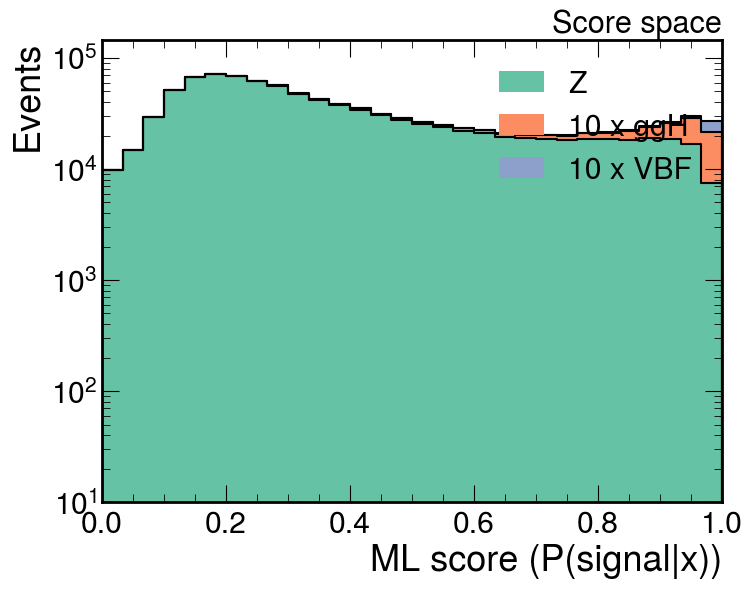

In [32]:
plot_histograms(scaled_score_hists, score_bins, x_label="ML score (P(signal|x))", title_right="Score space", scale_signal=10)

The Z area sits at mostly low scores of <~0.4 and steadily decreases towards 1, this shows that the model correctly pushes most background to low probability.

The signal (ggH and VBF) appears more often at higher scores than Z, so there is seperation but the overlap remainds as Z is still present up to high scores, which makes sense with AUC <1

______________________________________________________________________________________________________________

Running and inclusive and seperate fit on the histogram and then extract values + uncertainties to check our precision

In [28]:
nll_inc = partial(nll_merge, scaled_score_hists)
minuit_inc = Minuit(nll_inc, mu=1.0)
minuit_inc.migrad()
print(f"Inclusive: mu = {minuit_inc.values['mu']:.4f} ± {minuit_inc.errors['mu']:.4f}")

nll_sep = partial(nll_separate, scaled_score_hists)
minuit_sep = Minuit(nll_sep, mu_ggH=1.0, mu_VBF=1.0)
minuit_sep.migrad()
print(f"Separate: mu_ggH = {minuit_sep.values['mu_ggH']:.4f} ± {minuit_sep.errors['mu_ggH']:.4f}")
print(f"          mu_VBF = {minuit_sep.values['mu_VBF']:.4f} ± {minuit_sep.errors['mu_VBF']:.4f}")

Inclusive: mu = 1.0000 ± 0.0657
Separate: mu_ggH = 1.0000 ± 0.1266
          mu_VBF = 1.0000 ± 0.3203


The ML scores histograms are built then scaled, I then ran Minuit fits on those binned templates and performed an inclusive single and two paramater fit using Poisson NLL


 $\\mu$: 6.6% (target 6%) – close, but not better yet.\
$\mu_{\mathrm{ggH}}$: 12.5% (target 9%) – still a bit worse.\
$\mu_{\mathrm{VBF}}$: 35.8% (target 18%) – alot worse than the target.

And compared to the classical approach results, we get something similar.
mu = 1.0 ± 0.0923 \
mu_ggH = 1.0 ± 0.1249 \
mu_VBF = 1.0 ± 0.3578 


So we still have some work to do, potential areas are as follows:
1. Stronger classifier (tuned GB / XGBoost / multiclass).
3. Per-channel training and combination.
4. 2D bins in $(p_{\mathrm{ggH}}, p_{\mathrm{VBF}})$ to decorrelate the processes
______________________________________________________________________________________________________________

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def train_and_eval_models():
    models = {
        "GradientBoosting": GradientBoostingClassifier(random_state=42),
        "RandomForest": RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=42
        ),
        "XGBoost": XGBClassifier(
            n_estimators=600,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            learning_rate=0.05,
            reg_lambda=1.0,
            objective="binary:logistic",
            eval_metric="auc",
            random_state=42,
            n_jobs=-1
        )
    }
    results = {}
    for name, mdl in models.items():
        pipe = Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("clf", mdl)
        ])
        pipe.fit(X_train, y_train)
        valid_scores = pipe.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, valid_scores)
        results[name] = (pipe, auc)
        print(f"{name} AUC: {auc:.4f}")
    return results

model_results = train_and_eval_models()
# Pick best by AUC
best_name = max(model_results.items(), key=lambda kv: kv[1][1])[0]
model_pipe = model_results[best_name][0]
print(f"Selected model: {best_name}")

# Score all events with selected model
df_all["ml_score"] = model_pipe.predict_proba(X_all)[:, 1]

# Try uniform and quantile, keep the better one
uniform_hists, uniform_bins = build_score_histograms(df_all, processes, nbins=30, quantile=False)
quant_hists, quant_bins = build_score_histograms(df_all, processes, nbins=30, quantile=True)

def fit_and_report(hists, label):
    nll_inc = partial(nll_merge, hists)
    mi_inc = Minuit(nll_inc, mu=1.0)
    mi_inc.migrad()
    nll_sep = partial(nll_separate, hists)
    mi_sep = Minuit(nll_sep, mu_ggH=1.0, mu_VBF=1.0)
    mi_sep.migrad()
    def prec(val, err): return 100.0 * err / val
    print(f"[{label}] mu = {mi_inc.values['mu']:.4f} ± {mi_inc.errors['mu']:.4f}  ({prec(mi_inc.values['mu'], mi_inc.errors['mu']):.2f}%)")
    print(f"[{label}] mu_ggH = {mi_sep.values['mu_ggH']:.4f} ± {mi_sep.errors['mu_ggH']:.4f}  ({prec(mi_sep.values['mu_ggH'], mi_sep.errors['mu_ggH']):.2f}%)")
    print(f"[{label}] mu_VBF = {mi_sep.values['mu_VBF']:.4f} ± {mi_sep.errors['mu_VBF']:.4f}  ({prec(mi_sep.values['mu_VBF'], mi_sep.errors['mu_VBF']):.2f}%)")
    return {
        "mu_pct": prec(mi_inc.values['mu'], mi_inc.errors['mu']),
        "mu_ggH_pct": prec(mi_sep.values['mu_ggH'], mi_sep.errors['mu_ggH']),
        "mu_VBF_pct": prec(mi_sep.values['mu_VBF'], mi_sep.errors['mu_VBF'])
    }

print("=== Fits (Uniform bins) ===")
uniform_metrics = fit_and_report(uniform_hists, "Uniform")
print("=== Fits (Quantile bins) ===")
quant_metrics = fit_and_report(quant_hists, "Quantile")

# Choose best strategy for each metric
chosen = "Quantile" if quant_metrics["mu_pct"] < uniform_metrics["mu_pct"] else "Uniform"
print(f"Chosen for inclusive mu: {chosen}")

GradientBoosting AUC: 0.8871
RandomForest AUC: 0.8889
XGBoost AUC: 0.8941
Selected model: XGBoost
=== Fits (Uniform bins) ===
[Uniform] mu = 1.0000 ± 0.0584  (5.84%)
[Uniform] mu_ggH = 1.0000 ± 0.1507  (15.07%)
[Uniform] mu_VBF = 1.0000 ± 0.4815  (48.15%)
=== Fits (Quantile bins) ===
[Quantile] mu = 1.0000 ± 0.0513  (5.13%)
[Quantile] mu_ggH = 1.0000 ± 0.0845  (8.45%)
[Quantile] mu_VBF = 1.0000 ± 0.1395  (13.95%)
Chosen for inclusive mu: Quantile


So we have now beaten the CMS targets with the quantile bins. The reason these perform better is because in Uniform bins the fixed-widths mean that the high-score tail ends have very few events -> large poisson variance and thus weaker constraints especially for the rare VBF. With Quantile the bin edges are chosen so that each bin has roughly equal number of total events. This avoids sparsley populated tail bins which means we have more stable likelihood curvature and thus reduced parameter uncertainties.
______________________________________________________________________________________________________________

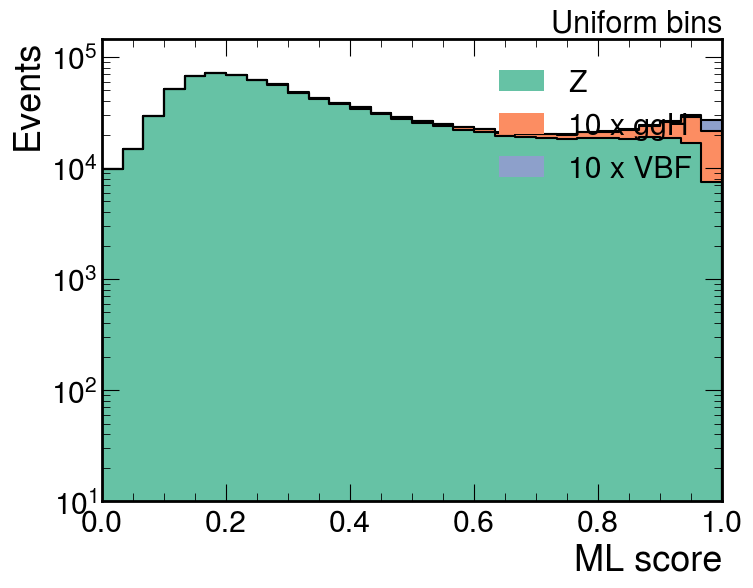

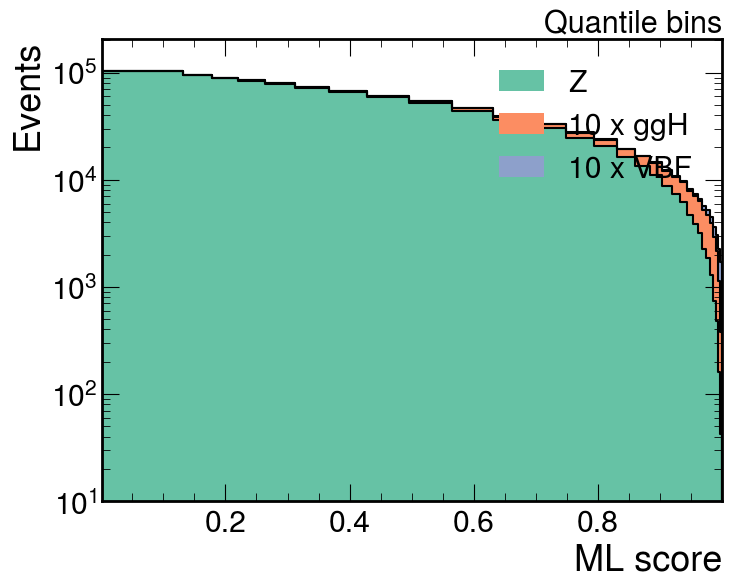

In [35]:
# Compare uniform vs quantile score histograms
plot_histograms(uniform_hists, uniform_bins, x_label="ML score", title_right="Uniform bins", scale_signal=10)
plot_histograms(quant_hists, quant_bins, x_label="ML score", title_right="Quantile bins", scale_signal=10)

______________________________________________________________________________________________________________
So we obviously won't get 3 distinct non-overlapping blocks for each signal. Here the ggH and VBF are pushed to the high scores and Z to the low scores and because the yields are so different the Z block dominates the graph.

To help see each better I tried a normalized comparison to just see the shapes better

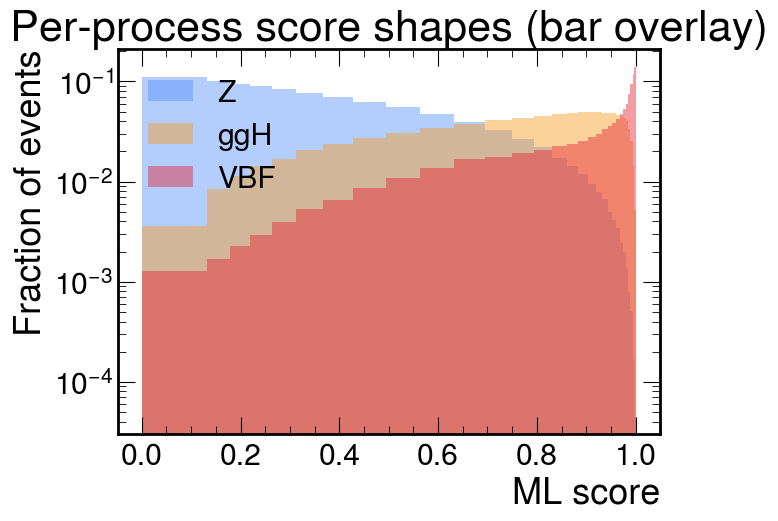

In [ ]:
def plot_score_shapes_bar(df, processes, bins, normalize=True):
    """
    normalize: per-process normalization (area = 1)
    """
    hists = {}
    for p in processes:
        vals = df.loc[df.process == p, "ml_score"].values
        h, _ = np.histogram(vals, bins=bins)
        hists[p] = h.astype(float)

    fig, ax = plt.subplots(figsize=(7,5))
    width = np.diff(bins)
    centers = bins[:-1]
    for i, p in enumerate(processes):
        h = hists[p]
        if normalize:
            h = h / h.sum()
        ax.bar(centers, h, width=width, alpha=0.45, label=p, align="edge")
    ax.set_xlabel("ML score")
    ax.set_ylabel("Fraction of events" if normalize else "Events")
    ax.set_yscale("log")
    ax.legend()
    ax.set_title("Per-process score shapes (bar overlay)")
    plt.show()

plot_score_shapes_bar(df_all, processes, quant_bins, normalize=True)


______________________________________________________________________________________________________________
To try get better results, I decided to do some research online on what could be done. Came across this video : [Probability Calibration for Classification (Platt, isotonic, logistic and beta)](https://www.youtube.com/watch?v=O5undKIazqs) using sklearn.calibration and thought I'd try it

Probability calibration, raw scores from the model aren't perfect probabilities and the calibration reshapes it so that a score of 0.7 actually means 70% of those events are signal. Can make tigther bins at high scores

c:\Users\Mihir Koka\Desktop\IMPERIAL courses\Imperial-work\.venv\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


=== Pre calibration (quantile) ===
[PreCal] mu = 1.0000 ± 0.0513  (5.13%)
[PreCal] mu_ggH = 1.0000 ± 0.0845  (8.45%)
[PreCal] mu_VBF = 1.0000 ± 0.1395  (13.95%)
=== Post calibration (quantile) ===
[PostCal] mu = 1.0000 ± 0.0509  (5.09%)
[PostCal] mu_ggH = 1.0000 ± 0.0844  (8.44%)
[PostCal] mu_VBF = 1.0000 ± 0.1373  (13.73%)

Delta precisions (negative is improvement):
mu: -0.05 pct points
mu_ggH: -0.01 pct points
mu_VBF: -0.22 pct points


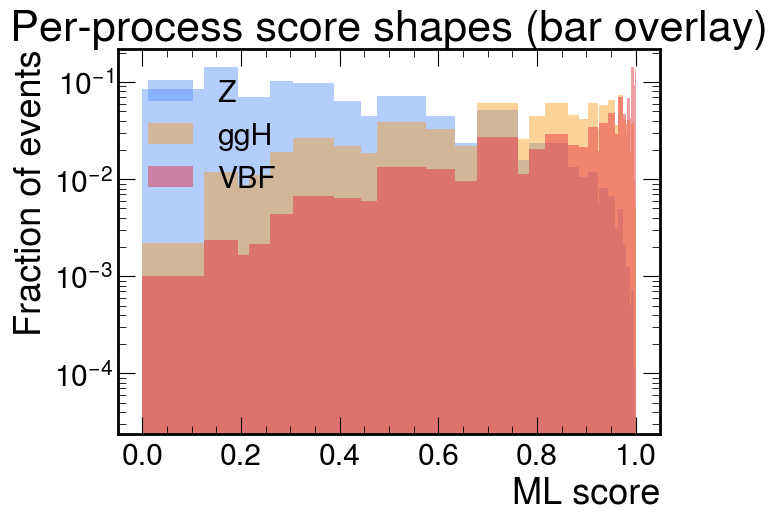

In [42]:
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(model_pipe, method="isotonic", cv="prefit")
calibrator.fit(X_valid, y_valid)

df_all["ml_score_cal"] = calibrator.predict_proba(X_all)[:, 1]

def build_score_histograms_with_col(df, processes, score_col="ml_score", nbins=30, quantile=True):
    if quantile:
        edges = np.quantile(df[score_col], np.linspace(0, 1, nbins + 1))
        bins = np.unique(edges)
    else:
        bins = np.linspace(0.0, 1.0, nbins + 1)
    raw = {}
    for proc in processes:
        vals = df.loc[df.process == proc, score_col].values
        raw[proc] = np.histogram(vals, bins=bins)[0]
    scaled = scale_histograms_to_correct_yield({k: v.copy() for k, v in raw.items()})
    return scaled, bins

# Pre calibration (uses ml_score)
pre_hists, pre_bins = build_score_histograms_with_col(df_all, processes, score_col="ml_score", nbins=30, quantile=True)
# Post calibration (uses ml_score_cal)
post_hists, post_bins = build_score_histograms_with_col(df_all, processes, score_col="ml_score_cal", nbins=30, quantile=True)

print("=== Pre calibration (quantile) ===")
pre_metrics = fit_and_report(pre_hists, "PreCal")

print("=== Post calibration (quantile) ===")
post_metrics = fit_and_report(post_hists, "PostCal")

def delta(a, b): return b - a
print("\nDelta precisions (negative is improvement):")
print(f"mu: {delta(pre_metrics['mu_pct'], post_metrics['mu_pct']):+.2f} pct points")
print(f"mu_ggH: {delta(pre_metrics['mu_ggH_pct'], post_metrics['mu_ggH_pct']):+.2f} pct points")
print(f"mu_VBF: {delta(pre_metrics['mu_VBF_pct'], post_metrics['mu_VBF_pct']):+.2f} pct points")

# Shape comparison (calibrated distribution)
plot_score_shapes_bar(df_all.rename(columns={"ml_score_cal": "ml_score"}), processes, post_bins, normalize=True)

As seen this method does give us some marginal improvements with mu and mu_ggH and some decent improvement with mu_VBF. It seems VBF scores often gained the most improvement when compared to the classical method, this might be because VBF is the lowest yield class. Raw model scores in that sparse tail area are noisier and less well calibrated.


Further with VBF we had a case where it was dominated by just a few underpopulated extremem bins, small absolute changes in expected counts translate into larger % error improvements.



______________________________________________________________________________________________________________
##### Summary and conclusion

- In this notebook I loaded all six datasets (et, mt, tt+Z, ggh, VBF) and document variables.
- Created a merged DF, handled '-9999' NaN terms and selected numeric features only
- Trained multiple binary classifiers (GB, RF, XGBoost) and selected the best performing one by ROC and AUC validation
- Presented process-seperated ML score histograms, applied yield scaling (with the provided methods) and then performed Minuit fits for mu, mu_ggh and mu_VBF
- compared uniform and quantile binning to find quantile binning improved precision
- Applied isotonic probability calibration and rebuilt the bins to small but measurable improvments in precision for all 3 parameters.

The core requirement of beating the target preicision was satisfied and there were significant improvements, especially for the VBF component.